### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

In [1]:
# Download the data base
!wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
unzip:  cannot find or open FullIJCNN2013.zip, FullIJCNN2013.zip.zip or FullIJCNN2013.zip.ZIP.


In [2]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [3]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

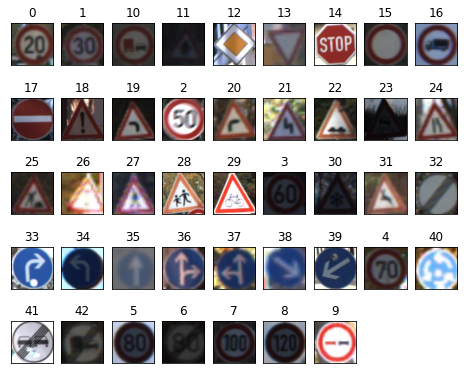

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
print(tr_signs[0].shape)
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

(224, 224, 3)
Using TensorFlow backend.


In [6]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1,step=len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1,step=len(model_history.history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Assignment 1: Multi-Layer Perceptron

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import experimental

def build_model_v1():
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model

def build_model_v2():
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model

def build_model_v3():
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model

In [9]:
model = build_model_v1()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

Epoch 1/40
5/5 - 8s - loss: 4.0003 - accuracy: 0.0583 - val_loss: 3.7188 - val_accuracy: 0.0595
Epoch 2/40
5/5 - 2s - loss: 3.6711 - accuracy: 0.0917 - val_loss: 3.6757 - val_accuracy: 0.0556
Epoch 3/40
5/5 - 2s - loss: 3.5309 - accuracy: 0.1100 - val_loss: 3.6368 - val_accuracy: 0.0675
Epoch 4/40
5/5 - 2s - loss: 3.4250 - accuracy: 0.1417 - val_loss: 3.6059 - val_accuracy: 0.0556
Epoch 5/40
5/5 - 2s - loss: 3.3087 - accuracy: 0.1567 - val_loss: 3.5835 - val_accuracy: 0.0635
Epoch 6/40
5/5 - 2s - loss: 3.2250 - accuracy: 0.1900 - val_loss: 3.5624 - val_accuracy: 0.0635
Epoch 7/40
5/5 - 2s - loss: 3.1291 - accuracy: 0.1917 - val_loss: 3.5379 - val_accuracy: 0.0714
Epoch 8/40
5/5 - 2s - loss: 3.0939 - accuracy: 0.1783 - val_loss: 3.5131 - val_accuracy: 0.1032
Epoch 9/40
5/5 - 2s - loss: 3.0373 - accuracy: 0.1933 - val_loss: 3.4880 - val_accuracy: 0.1032
Epoch 10/40
5/5 - 2s - loss: 3.0168 - accuracy: 0.2267 - val_loss: 3.4694 - val_accuracy: 0.0992
Epoch 11/40
5/5 - 2s - loss: 2.9581 - a

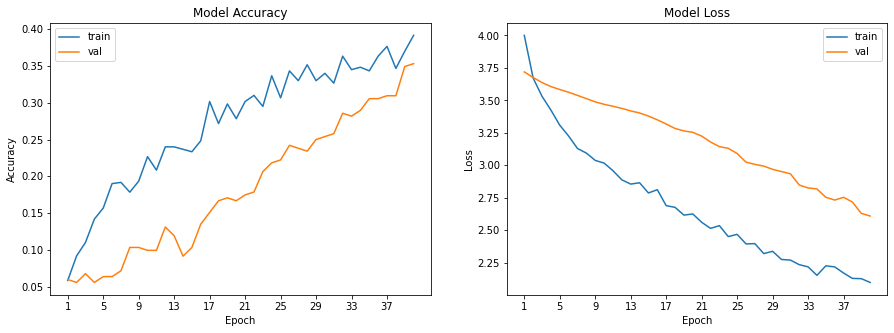

In [10]:
data = model.fit(tr_signs, tr_labels, batch_size=128, epochs=40, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

plot_model_history(data)

In [11]:
model = build_model_v2()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               19267712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)              

Epoch 1/40
5/5 - 6s - loss: 3.9728 - accuracy: 0.0300 - val_loss: 3.7618 - val_accuracy: 0.0040
Epoch 2/40
5/5 - 2s - loss: 3.9398 - accuracy: 0.0250 - val_loss: 3.7505 - val_accuracy: 0.0198
Epoch 3/40
5/5 - 2s - loss: 3.8256 - accuracy: 0.0417 - val_loss: 3.7405 - val_accuracy: 0.0119
Epoch 4/40
5/5 - 2s - loss: 3.8316 - accuracy: 0.0267 - val_loss: 3.7296 - val_accuracy: 0.0159
Epoch 5/40
5/5 - 2s - loss: 3.7927 - accuracy: 0.0400 - val_loss: 3.7178 - val_accuracy: 0.0437
Epoch 6/40
5/5 - 2s - loss: 3.8010 - accuracy: 0.0400 - val_loss: 3.7084 - val_accuracy: 0.0635
Epoch 7/40
5/5 - 2s - loss: 3.8021 - accuracy: 0.0433 - val_loss: 3.6984 - val_accuracy: 0.0714
Epoch 8/40
5/5 - 2s - loss: 3.7543 - accuracy: 0.0467 - val_loss: 3.6877 - val_accuracy: 0.0873
Epoch 9/40
5/5 - 2s - loss: 3.7451 - accuracy: 0.0467 - val_loss: 3.6777 - val_accuracy: 0.0992
Epoch 10/40
5/5 - 2s - loss: 3.6837 - accuracy: 0.0817 - val_loss: 3.6701 - val_accuracy: 0.1190
Epoch 11/40
5/5 - 2s - loss: 3.6659 - a

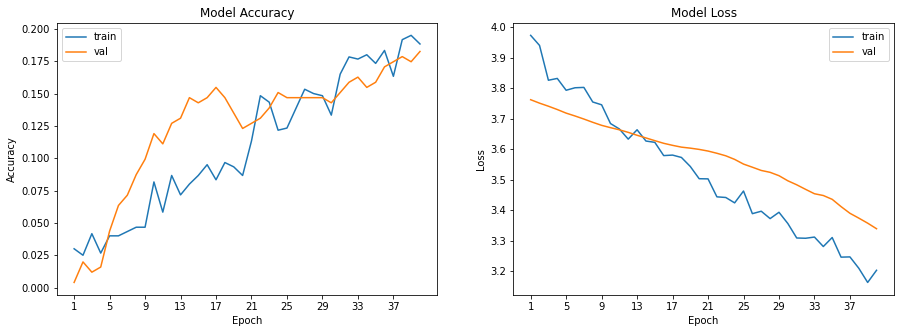

In [12]:
data = model.fit(tr_signs, tr_labels, batch_size=128, epochs=40, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

plot_model_history(data)

In [13]:
model = build_model_v3()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              154141696 
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)             

Epoch 1/40
5/5 - 13s - loss: 4.0760 - accuracy: 0.0267 - val_loss: 3.7456 - val_accuracy: 0.0079
Epoch 2/40
5/5 - 5s - loss: 3.8586 - accuracy: 0.0450 - val_loss: 3.7336 - val_accuracy: 0.0794
Epoch 3/40
5/5 - 5s - loss: 3.7365 - accuracy: 0.0583 - val_loss: 3.7172 - val_accuracy: 0.0833
Epoch 4/40
5/5 - 5s - loss: 3.6600 - accuracy: 0.0667 - val_loss: 3.7262 - val_accuracy: 0.0794
Epoch 5/40
5/5 - 5s - loss: 3.5733 - accuracy: 0.0833 - val_loss: 3.7082 - val_accuracy: 0.0794
Epoch 6/40
5/5 - 10s - loss: 3.4987 - accuracy: 0.0933 - val_loss: 3.6801 - val_accuracy: 0.0873
Epoch 7/40
5/5 - 5s - loss: 3.4662 - accuracy: 0.1317 - val_loss: 3.6768 - val_accuracy: 0.0873
Epoch 8/40
5/5 - 5s - loss: 3.3858 - accuracy: 0.1433 - val_loss: 3.6694 - val_accuracy: 0.0913
Epoch 9/40
5/5 - 5s - loss: 3.2940 - accuracy: 0.1633 - val_loss: 3.6414 - val_accuracy: 0.0913
Epoch 10/40
5/5 - 5s - loss: 3.2557 - accuracy: 0.1467 - val_loss: 3.6121 - val_accuracy: 0.0992
Epoch 11/40
5/5 - 5s - loss: 3.2319 -

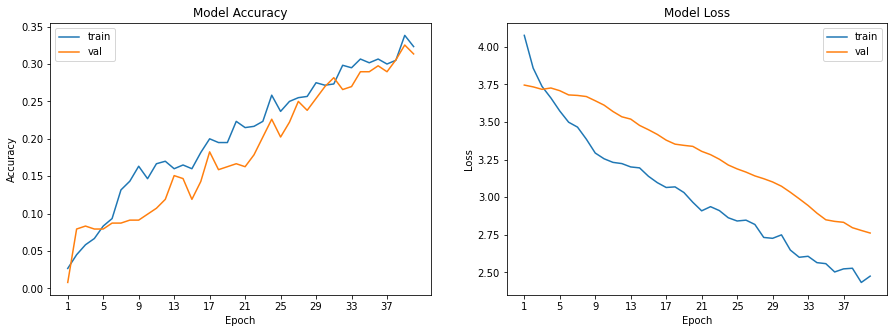

In [14]:
data = model.fit(tr_signs, tr_labels, batch_size=128, epochs=40, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

plot_model_history(data)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D

def create_block(block_input, n_filtros):
    x = block_input
    for i in range(2):
        x = Conv2D(n_filtros, kernel_size=(3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

def build_conv(include_dropout = True): # De https://www.kaggle.com/mahtabshaan/autoencoder-as-feature-extractor-cifar10
    net_input = Input((224,224,3))

    block1 = create_block(net_input, 32)
    x = MaxPooling2D(pool_size=(2, 2))(block1)
    if include_dropout:
        x = Dropout(0.2)(x)

    block2 = create_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(block2)
    if include_dropout:
        x = Dropout(0.3)(x)

    block3 = create_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(block3)
    if include_dropout:
        x = Dropout(0.3)(block3)

    x = Flatten()(x)
    output = Dense(43, activation='softmax')(x)
    return Model(net_input, output)


In [16]:
# Convolutional Neural Network (CNN)
# Here you are allowed to use convolutional layers
# You may use also any regularizacion (see class slides)

import keras.backend as K

model = build_conv()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_14 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 224, 224, 32)      128   

In [17]:
data = model.fit(tr_signs, tr_labels, batch_size=64, epochs=10, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

plot_model_history(data)

Epoch 1/10
